In [1]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [2]:
import sys
sys.path.append("../")
from src.CNN import CNN, compute_accuracy_metrics, multiclass_accuracy_metrics, list2onehot, onehot2list

In [3]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [4]:
def random_padding(img, thickness=1):
    # img = a x b image 
    [a,b] = img.shape
    Y = np.zeros(shape=[a+thickness, b+thickness])
    r_loc = np.random.choice(np.arange(thickness+1))
    c_loc = np.random.choice(np.arange(thickness+1))
    Y[r_loc:r_loc+a, c_loc:c_loc+b] = img
    return Y

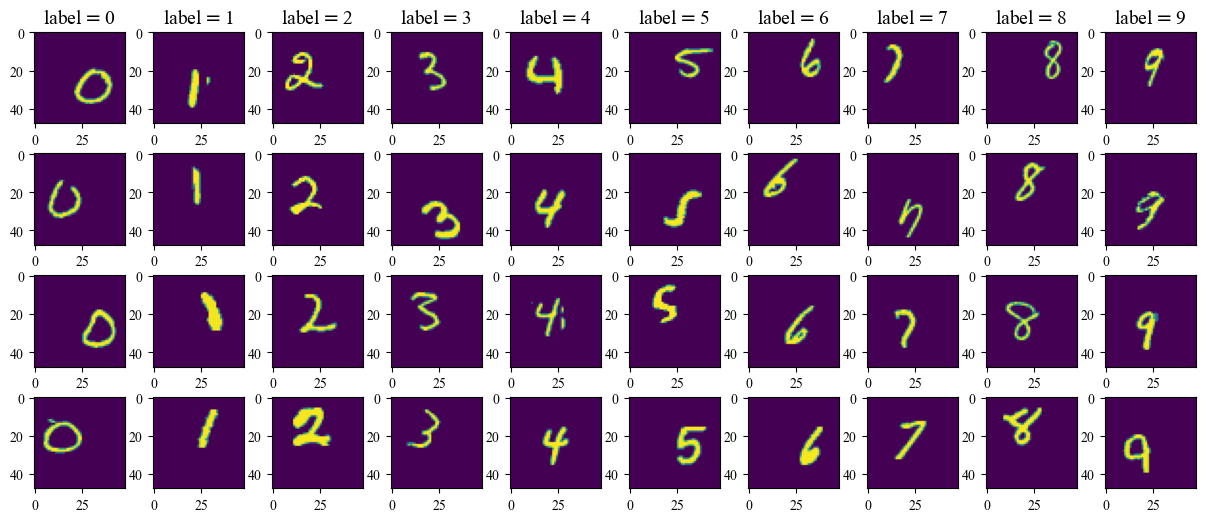

In [5]:
# Load MNIST images 
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

# Plot some sample images 
ncols = 10
nrows = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[15, 6.5])
for j in np.arange(ncols):
    for i in np.arange(nrows):
        idx = np.where(y==str(j)) # index of all images of digit 'j'
        idx = np.asarray(idx)[0,:] # make idx from tuple to array
        idx_subsampled = np.random.choice(idx, nrows)
        img = X[idx_subsampled[i],:].reshape(28,28)
        img_padded = random_padding(img, thickness=20)
        ax[i,j].imshow(img_padded, cmap='viridis')
        # ax[i,j].title.set_text("label=%s" % y[idx_subsampled[j]]) 
        if i == 0:
            # ax[j,i].set_ylabel("label=%s" % y[idx_subsampled[j]]) 
            ax[i,j].set_title("label$=$%s" % y[idx_subsampled[i]], fontsize=14) 
        # ax[i].legend()
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.savefig('MNIST_padded_ex1.pdf', bbox_inches='tight')

In [6]:
def sample_multiclass_MNIST_padding(list_digits=['0','1', '2'], full_MNIST=[X,y], padding_thickness=10):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    # pad each 28 x 28 image with zeros so that it has now "padding_thickness" more rows and columns
    # The original image is superimposed at a uniformly chosen location 
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        img_padded = random_padding(X01[i,:].reshape(28,28), thickness=padding_thickness)
        img_padded_vec = img_padded.reshape(1,-1)
        if U<0.8:
            X_train.append(img_padded_vec[0,:].copy())
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(img_padded_vec[0,:].copy())
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

In [13]:
# Simple MNIST binary classification experiments 

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=['0','1'], 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=0)

# data subsampling 
train_size = 100

idx = np.random.choice(np.arange(len(y_train)), train_size)
X_train0 = X_train[idx, :]/np.max(X_train)
y_train0 = y_train[idx, :]

# preprocessing 
out = []
# populate the tuple list with the data
for i in range(X_train0.shape[0]):
    item = list((X_train0[i,:].reshape(1,28,28), y_train0[i,:])) 
    out.append(item)
    
# CNN training
CNN0 = CNN(training_data = out,
           f = 5, # conv filter dim
           f_pool = 2, # maxpool filter dim
           num_filt1 = 8, # num filters for the first conv layer
           num_filt2 = 8, # num filters for the second conv layer
           conv_stride = 1,
           pool_stride = 2,
           hidden_nodes = 128)

CNN0.train(lr = 0.01,
           beta1 = 0.95,
           beta2 = 0.99,
           minibatch_size = 32,
           num_epochs = 20,
           verbose = True)



100%|██████████| 14780/14780 [00:01<00:00, 7597.60it/s]


self.img_x_dim 28
LR:0.01, MiniBatch Size:32


  5%|▌         | 1/20 [00:16<05:12, 16.47s/it]

epoch 0, error 0.69521


 30%|███       | 6/20 [01:40<03:39, 15.70s/it]

epoch 5, error 0.07649


 55%|█████▌    | 11/20 [02:54<02:15, 15.04s/it]

epoch 10, error 0.26731


 80%|████████  | 16/20 [04:09<01:00, 15.06s/it]

epoch 15, error 0.00288


100%|██████████| 20/20 [05:09<00:00, 15.46s/it]


[np.float64(0.6931186501738459),
 np.float64(0.6914245409003106),
 np.float64(0.6936782704448932),
 np.float64(0.6952067293601052),
 np.float64(0.6925906442618176),
 np.float64(0.6913995371888836),
 np.float64(0.6917086491721257),
 np.float64(0.692017719189247),
 np.float64(0.6893718808892688),
 np.float64(0.6859910356208968),
 np.float64(0.6796203700548142),
 np.float64(0.6425453263211418),
 np.float64(0.6449399451293827),
 np.float64(0.6314053063192824),
 np.float64(0.5613272349844652),
 np.float64(0.5328041458555718),
 np.float64(0.45660861618093784),
 np.float64(0.3782046465383064),
 np.float64(0.23990132190390615),
 np.float64(0.14284644607208724),
 np.float64(0.0985252620630132),
 np.float64(0.10561682974589637),
 np.float64(0.27679584420785003),
 np.float64(0.07649087700862688),
 np.float64(0.017909274513833937),
 np.float64(0.0025788373358597697),
 np.float64(0.19177894143628443),
 np.float64(0.8273756113421386),
 np.float64(0.14690704613129038),
 np.float64(0.09459774118803063

In [14]:
# CNN prediction

X_test /= np.max(X_test)
print('X_test.shape', X_test.shape)
out_test = []


for i in range(X_test.shape[0]):
    out_test.append((X_test[i,:].reshape(1,28,28)))
                
y_hat = CNN0.predict(image_list=out_test)

y_test_label = np.asarray(onehot2list(y_test))
P_pred = np.asarray([p[1] for p in y_hat])

compute_accuracy_metrics(Y_test=y_test_label, P_pred=P_pred, use_opt_threshold=False, verbose=True)

X_test.shape (2962, 784)


100%|██████████| 2962/2962 [03:37<00:00, 13.62it/s]

AUC ===> 1.000
Opt_threshold ===> 0.693
Accuracy ===> 0.997
Sensitivity ===> 0.996
Specificity ===> 0.998
Precision ===> 0.997
Fall_out ===> 0.004
Miss_rate ===> 0.002
Confusion matrix  ===> 
 [[1386    5]
 [   3 1568]]


{'Y_test': array([1, 1, 0, ..., 1, 0, 1], shape=(2962,)),
 'Y_pred': array([[1.],
        [1.],
        [0.],
        ...,
        [1.],
        [0.],
        [1.]], shape=(2962, 1)),
 'AUC': 0.9999427985947674,
 'Opt_threshold': np.float64(0.6934374898960236),
 'Accuracy': np.float64(0.9972991222147198),
 'Sensitivity': np.float64(0.9964054636951833),
 'Specificity': np.float64(0.9980903882877148),
 'Precision': np.float64(0.9968213604577241),
 'Fall_out': np.float64(0.0035945363048166786),
 'Miss_rate': np.float64(0.0019096117122851686),
 'Confusion_mx': array([[1386,    5],
        [   3, 1568]])}

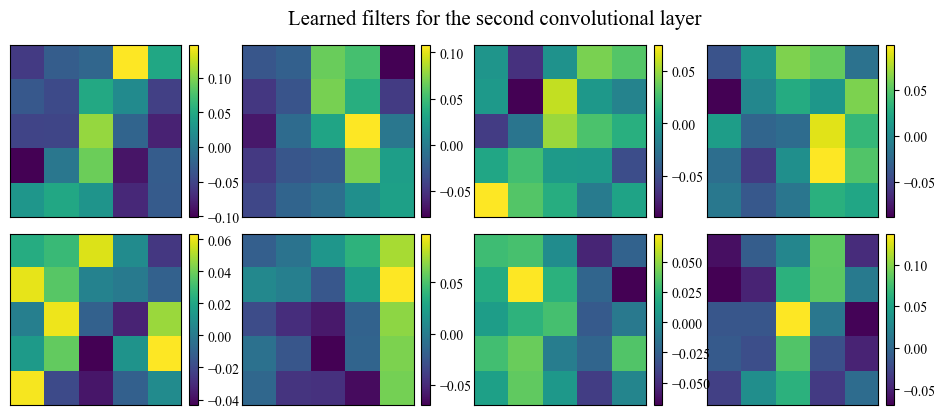

In [ ]:
# Draw Filters

f1 = CNN0.params.get('f1')

# make plot
nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=[10,4.5])

for i in np.arange(nrows):
    for j in np.arange(ncols):
        im = ax[i,j].imshow(f1[j + 4*i,0,:,:])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        fig.colorbar(im, ax=ax[i,j], fraction=0.0457, pad=0.04)
        
fig.suptitle("Learned filters for the first convolutional layer", fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.subplots_adjust(left=0.01, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.1)
plt.savefig('MNIST_CNN_filter_ex1.pdf', bbox_inches="tight")



In [ ]:
# Simple MNIST binary classification experiments 

thickness = 10
X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=['0','1'], 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=thickness)

# data subsampling 
train_size = 100

idx = np.random.choice(np.arange(len(y_train)), train_size)
X_train0 = X_train[idx, :]/np.max(X_train)
y_train0 = y_train[idx, :]

# preprocessing 
out = []
# populate the tuple list with the data
for i in range(X_train0.shape[0]):
    item = list((X_train0[i,:].reshape(1,28+thickness,28+thickness), y_train0[i,:])) 
    out.append(item)
    
# CNN training
CNN0 = CNN(training_data = out,
           f = 5, # conv filter dim
           f_pool = 2, # maxpool filter dim
           num_filt1 = 8, # num filters for the first conv layer
           num_filt2 = 8, # num filters for the second conv layer
           conv_stride = 1,
           pool_stride = 2,
           hidden_nodes = 128)

CNN0.train(lr = 0.01,
           beta1 = 0.95,
           beta2 = 0.99,
           minibatch_size = 32,
           num_epochs = 30,
           verbose = True)

# CNN prediction




idx = np.random.choice(np.arange(len(y_test)), 100)
X_test0 = X_test[idx, :]/np.max(X_test)
y_test0 = y_test[idx, :]

out_test = []

for i in range(X_test0.shape[0]):
    out_test.append((X_test0[i,:].reshape(1,28+thickness,28+thickness)))
                
y_hat = CNN0.predict(image_list=out_test)

y_test_label = np.asarray(onehot2list(y_test0))
P_pred = np.asarray([p[1] for p in y_hat])

compute_accuracy_metrics(Y_test=y_test_label, P_pred=P_pred, use_opt_threshold=False, verbose=True)





In [ ]:
# compute comparative multiclass classification metrics on test data

thinkness = 10
n_filters = [2, 5, 10, 15, 20]
list_digits=['0','1','2','3','4']

# Data preprocessing

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=['0','1'], 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=thinkness)
train_size_list = [50, 100, 200]

# make plot
ncols = len(train_size_list)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,5])

for t in np.arange(len(train_size_list)):
    accuracy_list_test = []
    accuracy_list_train = []
    
    train_size = train_size_list[t]
    idx = np.random.choice(np.arange(len(y_train)), train_size)
    X_train0 = X_train[idx, :]/np.max(X_train)
    y_train0 = y_train[idx, :]
    
    idx = np.random.choice(np.arange(len(y_test)), 100)
    X_test0 = X_test[idx, :]/np.max(X_test)
    y_test0 = y_test[idx, :]

    out = []
    out_train = []
    # populate the tuple list with the data
    for i in range(X_train0.shape[0]):
        item = list((X_train0[i,:].reshape(1,28+thinkness,28+thinkness), y_train0[i,:])) 
        out.append(item)
        out_train.append(X_train0[i,:].reshape(1,28+thinkness,28+thinkness))
        
    X_test /= np.max(X_test)
    out_test = []
    for i in range(X_test0.shape[0]):
        out_test.append((X_test0[i,:].reshape(1,28+thinkness,28+thinkness)))

    for M in n_filters:

        # CNN training
        CNN0 = CNN(training_data = out,
           f = 5, # conv filter dim
           f_pool = 2, # maxpool filter dim
           num_filt1 = M, # num filters for the first conv layer
           num_filt2 = M, # num filters for the second conv layer
           conv_stride = 1,
           pool_stride = 2,
           hidden_nodes = 128)

        CNN0.train(lr = 0.01,
                   beta1 = 0.95,
                   beta2 = 0.99,
                   minibatch_size = 32,
                   num_epochs = 100,
                   verbose = True)
        
        # CNN prediction
        print()
        y_hat_train = np.asarray(CNN0.predict(out_train))
        y_hat_test = np.asarray(CNN0.predict(out_test))

        y_train_label = np.asarray(onehot2list(y_train0))
        y_test_label = np.asarray(onehot2list(y_test0))

        results_train = multiclass_accuracy_metrics(Y_test=y_train0, P_pred=y_hat_train)
        results_test = multiclass_accuracy_metrics(Y_test=y_test0, P_pred=y_hat_test)

        accuracy_list_train.append(results_train.get('Accuracy'))
        accuracy_list_test.append(results_test.get('Accuracy'))
    
    ## Plot
    ax[t].plot(n_filters, accuracy_list_train, color='blue', label="train accuracy")
    ax[t].plot(n_filters, accuracy_list_test, color='red', label="test accuracy")
    ax[t].set_xlabel('Number of filters', fontsize=15)
    ax[t].set_ylabel('Classification Accuracy', fontsize=15)
    ax[t].title.set_text("num training ex = %i" % (train_size)) 
    ax[t].legend(fontsize=15)
            
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('MNIST_CNN_accuracy_ex1.pdf')

## Classifying non-aligned MNIST images 

100%|██████████| 35735/35735 [00:02<00:00, 15098.76it/s]


self.img_x_dim 28
LR:0.01, MiniBatch Size:16


  5%|▌         | 1/20 [00:07<02:21,  7.44s/it]

epoch 0, error 1.61035


 30%|███       | 6/20 [00:45<01:46,  7.63s/it]

epoch 5, error 1.57155


 55%|█████▌    | 11/20 [01:24<01:09,  7.71s/it]

epoch 10, error 1.49264


 80%|████████  | 16/20 [02:02<00:30,  7.60s/it]

epoch 15, error 0.52722


100%|██████████| 20/20 [02:33<00:00,  7.70s/it]


100%|██████████| 100/100 [00:09<00:00, 10.33it/s]


!!! confusion_mx [[ 9  0  0  2  0]
 [ 0 11  0  1  0]
 [ 0  0  0  9  0]
 [ 0  0  0 11  0]
 [ 0  0  0  7  0]]
!!! Accuracy 0.62
!!! confusion_mx [[11  0  0  5  0]
 [ 0 16  0  1  0]
 [ 0  0  0 28  1]
 [ 0  0  0 18  0]
 [ 0  0  0 20  0]]
!!! Accuracy 0.45


100%|██████████| 35735/35735 [00:01<00:00, 20991.77it/s]


self.img_x_dim 33
LR:0.01, MiniBatch Size:16


  5%|▌         | 1/20 [00:10<03:23, 10.69s/it]

epoch 0, error 1.61791


  5%|▌         | 1/20 [00:22<07:14, 22.84s/it]


KeyboardInterrupt: 

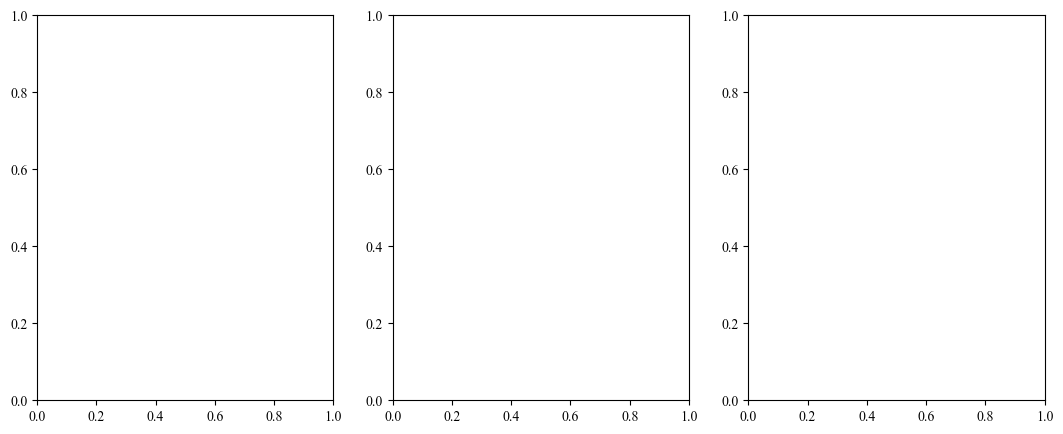

In [ ]:
# compute comparative multiclass classification metrics on test data

padding_list = [0, 5, 10, 15, 20]
list_digits=['0','1','2','3','4']
#list_digits=['0','1']

## Train
train_size_list = [50, 100, 200]

# make plot
ncols = len(train_size_list)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,5])

for t in np.arange(len(train_size_list)):
    accuracy_list_test = []
    accuracy_list_train = []
    
    train_size = train_size_list[t]
    
    for thickness in padding_list:
        # Data preprocessing
        X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                           full_MNIST=[X,y], 
                                                                           padding_thickness=thickness)
            
        idx = np.random.choice(np.arange(len(y_train)), train_size)
        X_train0 = X_train[idx, :]/np.max(X_train)
        y_train0 = y_train[idx, :]

        
        
        idx = np.random.choice(np.arange(len(y_test)), 100)
        X_test0 = X_test[idx, :]/np.max(X_test)
        y_test0 = y_test[idx, :]

        out = []
        out_train = []
        # populate the tuple list with the data
        for i in range(X_train0.shape[0]):
            item = list((X_train0[i,:].reshape(1, 28+thickness, 28+thickness), y_train0[i,:])) 
            
            out.append(item)
            out_train.append(X_train0[i,:].reshape(1, 28+thickness, 28+thickness))

        X_test /= np.max(X_test)
        out_test = []
        for i in range(X_test0.shape[0]):
            out_test.append((X_test0[i,:].reshape(1, 28+thickness, 28+thickness)))
    
    
    
        # CNN training
        CNN0 = CNN(training_data = out,
           f = 5, # conv filter dim
           f_pool = 2, # maxpool filter dim
           num_filt1 = 8, # num filters for the first conv layer
           num_filt2 = 8, # num filters for the second conv layer
           conv_stride = 1,
           pool_stride = 2,
           hidden_nodes = 64)

        CNN0.train(lr = 0.01,
                   beta1 = 0.95,
                   beta2 = 0.99,
                   minibatch_size = 32,
                   num_epochs = 50,
                   verbose = True)

        # CNN prediction
        print()
        y_hat_train = np.asarray(CNN0.predict(out_train))
        y_hat_test = np.asarray(CNN0.predict(out_test))

        y_train_label = np.asarray(onehot2list(y_train0))
        y_test_label = np.asarray(onehot2list(y_test0))

        results_train = multiclass_accuracy_metrics(Y_test=y_train0, P_pred=y_hat_train)
        results_test = multiclass_accuracy_metrics(Y_test=y_test0, P_pred=y_hat_test)

        accuracy_list_train.append(results_train.get('Accuracy'))
        accuracy_list_test.append(results_test.get('Accuracy'))
    
    ## Plot
    ax[t].plot(padding_list, accuracy_list_train, color='blue', label="train accuracy")
    ax[t].plot(padding_list, accuracy_list_test, color='red', label="test accuracy")
    ax[t].set_xlabel('Padding thickness', fontsize=15)
    ax[t].set_ylabel('Classification Accuracy', fontsize=15)
    ax[t].title.set_text("num training ex = %i" % (train_size)) 
    ax[t].legend(fontsize=15)
            
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('MNIST_CNN_accuracy_padding_ex3.pdf')